# Import packages

In [49]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

from feature_engine.datetime import DatetimeFeatures

from xgboost import XGBRegressor

import joblib

import matplotlib.pyplot as plt

# Settings

In [50]:
pd.set_option("display.max_columns",None)
sklearn.set_config(transform_output="default")

# Data Load

In [51]:
train = pd.read_csv('data/train.csv')
val = pd.read_csv('data/val.csv')
test = pd.read_csv('data/test.csv')

In [52]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187
...,...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info,4282
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info,13067
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info,4423
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info,7670


In [53]:
def X_y_split(df):
    X = df.drop('price', axis=1)
    y = df.price.copy() 
    return X,y 

In [54]:
X_train, y_train = X_y_split(train)
X_val, y_val = X_y_split(val)

In [55]:
X_test, y_test = X_y_split(test)

print(X_test.shape, y_test.shape)

(200, 9) (200,)


In [56]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


# Data Preprocessing 

In [57]:
dt_cols = ['date_of_journey',"dep_time","arrival_time"]
num_cols = ["duration","total_stops"]
cat_cols = ["airline","source","destination","additional_info"]

In [58]:
num_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="median")),
	("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

doj_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("extractor", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week", "day_of_month"], format="mixed")),
	("scaler", StandardScaler())
])

time_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("extractor", DatetimeFeatures(features_to_extract=["hour", "minute"], format="mixed")),
	("scaler", StandardScaler())
])

In [59]:
preprocessor = ColumnTransformer(transformers=[
	("num", num_transformer, num_cols),
	("cat", cat_transformer, cat_cols),
	("doj", doj_transformer, ["date_of_journey"]),
	("time", time_transformer, ["dep_time", "arrival_time"])
])

In [60]:
preprocessor.fit_transform(X_train)

array([[-1.09591823, -1.21213152,  0.        , ..., -0.14005709,
        -0.34523131,  1.49385907],
       [ 1.43569944,  0.31797533,  0.        , ..., -1.22986299,
        -0.93560684,  0.89104078],
       [ 1.82441239,  1.84808218,  0.        , ..., -0.68496004,
        -0.34523131, -1.21882323],
       ...,
       [-0.94641325, -1.21213152,  0.        , ..., -0.95741152,
        -0.78801296,  1.49385907],
       [ 0.18982461,  0.31797533,  0.        , ...,  1.22220029,
         1.1307075 , -1.52023237],
       [ 0.63833955,  0.31797533,  0.        , ..., -1.22986299,
        -0.19763743, -1.52023237]])

# Model Selection 

In [61]:
algorithms = {
	"Linear Regression": LinearRegression(),
	"Support Vector Machine": SVR(),
	"Random Forest": RandomForestRegressor(n_estimators=10),
	"XG Boost": XGBRegressor(n_estimators=10)
}

In [62]:
data = pd.concat([train, val], axis=0)

X_data, y_data = X_y_split(data)
print(X_data.shape, y_data.shape)

(800, 9) (800,)


In [63]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
	ax.plot(
		sizes,
		mean_scores,
		marker="o",
		label=label
	)

	ax.fill_between(
		x=sizes,
		y1=mean_scores - std_scores,
		y2=mean_scores + std_scores,
		alpha=0.5
	)

In [64]:
def plot_learning_curves(name, algorithm, figsize=(12, 4)):
	model = Pipeline(steps=[
		("pre", preprocessor),
		("alg", algorithm)
	])

	train_sizes, train_scores, test_scores = learning_curve(
		estimator=model,
		X=X_data,
		y=y_data,
		cv=3,
		scoring="r2",
		n_jobs=-1,
		random_state=42
	)

	
	mean_train_scores = np.mean(train_scores, axis=1)
	std_train_scores = np.std(train_scores, axis=1)
	train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

	mean_test_scores = np.mean(test_scores, axis=1)
	std_test_scores = np.std(test_scores, axis=1)
	test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

	fig, ax = plt.subplots(figsize=figsize)

	# training curve
	plot_curves(
		train_sizes,
		mean_train_scores,
		std_train_scores,
		f"Train ({train_score})",
		ax
	)

	# test curve
	plot_curves(
		train_sizes,
		mean_test_scores,
		std_test_scores,
		f"Test ({test_score})",
		ax
	)

	ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)

	ax.legend(loc="lower right")

	plt.show()

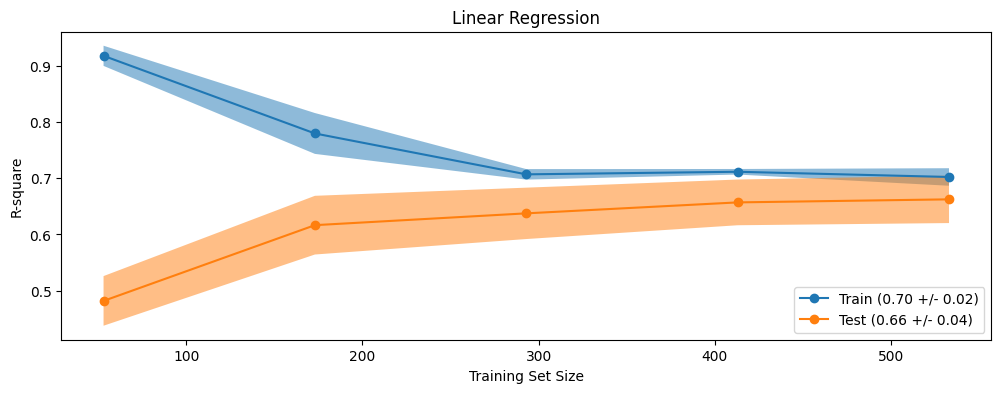

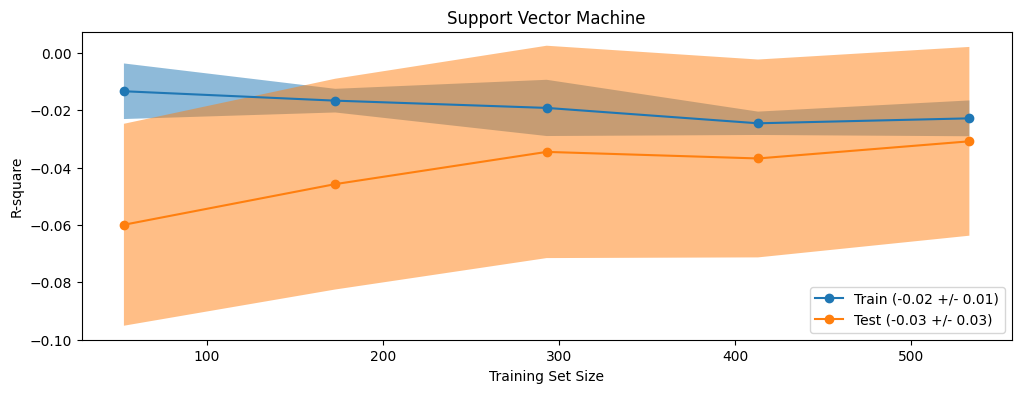

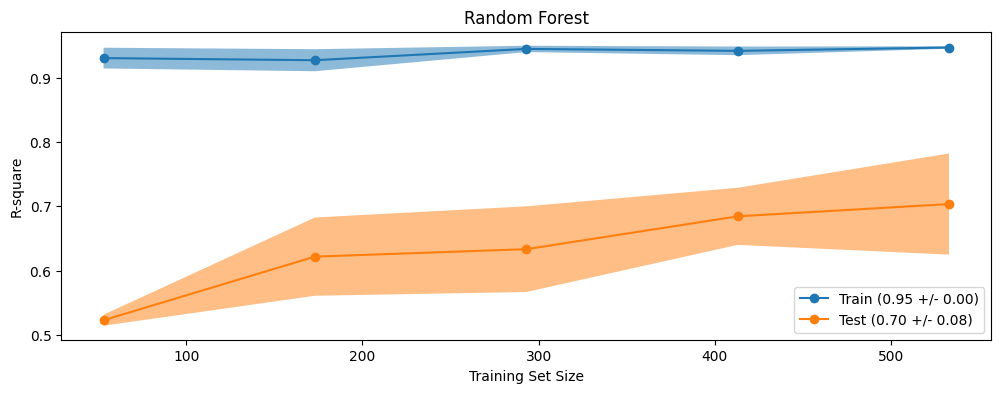

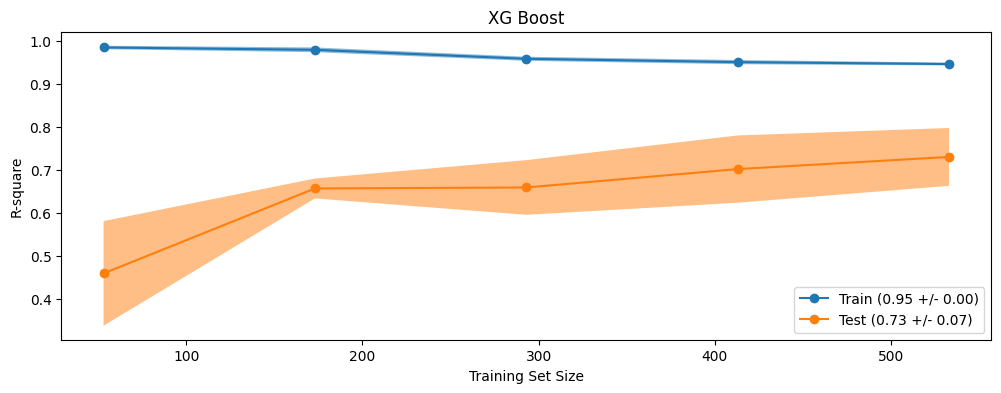

In [65]:
for name, alg in algorithms.items():
	plot_learning_curves(name, alg)

# Model Training

In [66]:
model = Pipeline(steps=[
	("pre", preprocessor),
	("rf", RandomForestRegressor(n_estimators=10))
])

In [67]:
model.fit(X_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

# Model Evaluation

In [68]:
def evaluate_model(X, y):
	y_pred = model.predict(X)
	return r2_score(y, y_pred)

In [69]:
print(f"R2 score on Training data is = {evaluate_model(X_data, y_data)}")


R2 score on Training data is = 0.9575618647454175


In [70]:
print(f"R2 score on Test data is = {evaluate_model(test, y_test)}")


R2 score on Test data is = 0.7186661442436328


# Model Persistence

In [71]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [72]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [73]:
y_pred = saved_model.predict(X_test)

r2_score(y_test, y_pred)

0.7186661442436328